In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu118


In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### Working with the Vision Transformer model (ViT-L/14) 

In [3]:
model, preprocess = clip.load("ViT-L/14")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x14d119c06790>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
clip.tokenize('Working with the Resnet101 model')

tensor([[49406,  1699,   593,   518,  4466,  2315,   272,   271,   272,  2863,
         49407,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Descriptions
descriptions = {
    "book": "An open book",
    "guitar_clean": "Picture of a guitar",
    "jetfighter": "F16 jet fighter",
    "submarine": "Submarine cruising in the ocean",
    "tank": "Modern Heavy Tank",
}

image_dir = "Images"
images = []

# Load and preprocess images
for filename in os.listdir(image_dir):
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
    image_tensor = preprocess(image)  # shape [3, 224, 224]
    images.append(image_tensor)

# Stack and send to device
image_input = torch.stack(images).to(device)

# Tokenize the text
text_tokens = clip.tokenize(["This is " + desc for desc in descriptions.values()]).to(device)
plt.show()

In [14]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()


In [15]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
# Plotting similarity matrix
plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3, cmap="viridis")  # or other colormaps

count = len(descriptions)

plt.yticks(range(count), list(descriptions.values()), fontsize=18)
plt.xticks([])

for i, image_tensor in enumerate(images):
    # Convert tensor to numpy and transpose to (H, W, C)
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np, 0, 1)  # In case of normalization
    plt.imshow(image_np, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add similarity score text
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# Remove borders
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)
plt.colorbar()
plt.show()


In [20]:
from torchvision.datasets import CIFAR100

# Download CIFAR100 class names (no need to load the actual images)
cifar = CIFAR100(os.path.expanduser("~/.cache"), download=True)

# Create prompt sentences like "This is a photo of a ... "
text_descriptions = [f"This is a photo of a {label}" for label in cifar.classes]
text_tokens = clip.tokenize(text_descriptions).to(device)

# Encode the text prompts with CLIP
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [21]:
# Encode image features
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

# Compute similarity scores (logits)
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)  # [N, 100]

top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9468161].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7630657..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520971..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


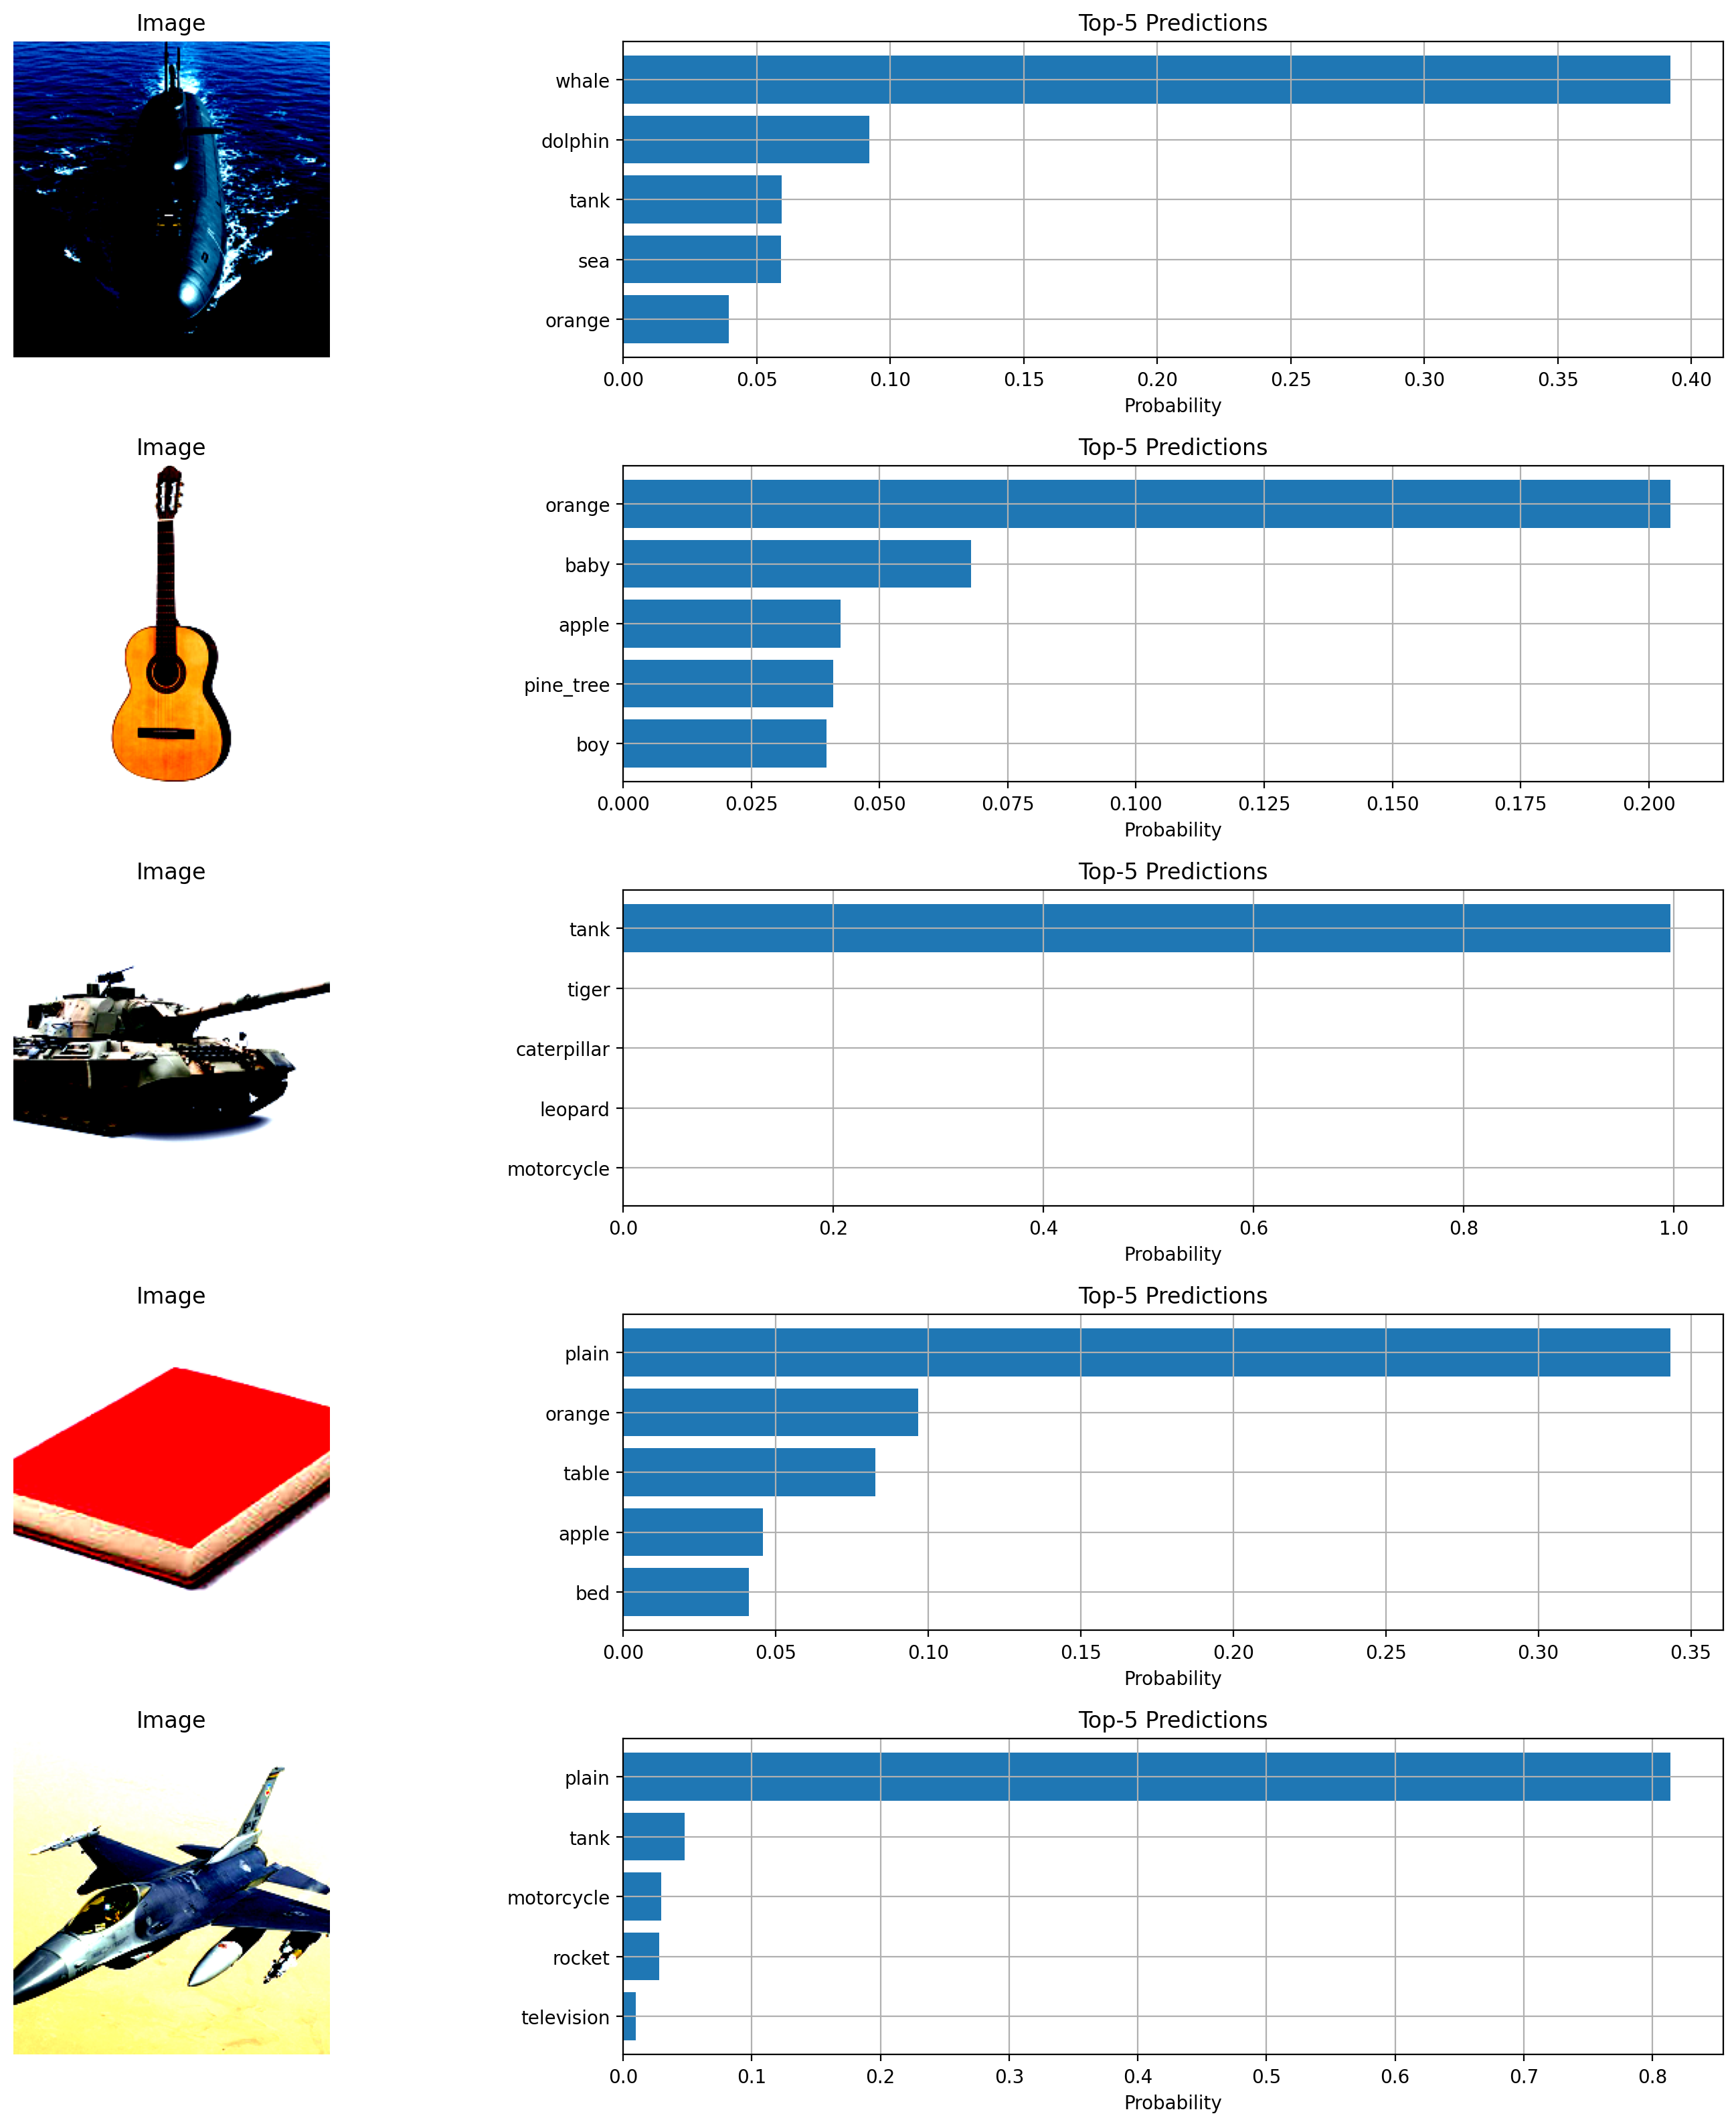

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 16))

for i, image in enumerate(images):
    # Show image
    plt.subplot(len(images), 2, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Image", fontsize=12)

    # Show bar plot of top-5 predictions
    plt.subplot(len(images), 2, 2 * i + 2)
    y = np.arange(5)
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.yticks(y, [cifar.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("Probability")
    plt.title("Top-5 Predictions", fontsize=12)
    plt.grid(True)

plt.tight_layout()
plt.show()
